<a href="https://www.kaggle.com/code/thikhuyenle/text-classification?scriptVersionId=183439473" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**In this notebook, we are going to build and train a simple neural network model which combine Conv1D and LSTM to for text classification**

**The dataset consists of 50.000 movie reviews, and includes 2 groups: positive and negative**

https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

## Table of content

### [I. Data preparation](#Data_preparation)
**[1. Data loading](#Data_loading)**

**[2. Text cleaning](#Text_cleaning)**
- Removing url
- Removing html
- Removing punctuations
- Removing special characters
- Removing emojis 
- Lower text

**[3. Data processing](#Data_processing)**
- Train/val/test splitting
- Tokenization
- Convert texts to sequences 
- Sequence padding 

### [II. Build and train the model](#Build_and_train_model)


### [III. Test the model on unseen dataset](#Prediction_on_unseen_dataset)

______________________________________________________________________________________________________________________

<a name = 'data_preparation'></a>
## I. Data preparation

<a name = 'data_loading'></a>
### 1. Data loading


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive




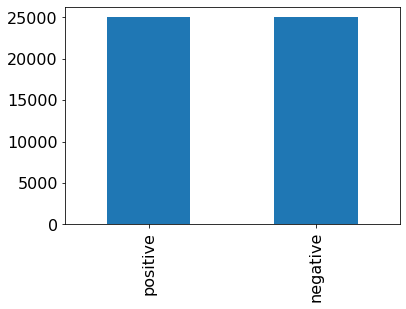

In [1]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':16})

data_path = '/kaggle/input/imdb-dataset-of-50k-movie-reviews/'

data = pd.read_csv(data_path + 'IMDB Dataset.csv')

# display the first 5 rows of data
print()
print(data.head(5))

print('\n')
plt.figure(figsize = (6,4))
data['sentiment'].value_counts().plot(kind = 'bar')
plt.show()

The dataset consists of two groups: 
+ 25000 positive reviews 
+ 25000 positive reviews

<a name = 'text_cleaning'></a>
### 2. Text cleaning

In [3]:
import re
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

def remove_url(text):
    url_tag = re.compile(r'https://\S+|www\.\S+')
    text = url_tag.sub(r'', text)
    return text

def remove_html(text):
    html_tag = re.compile(r'<.*?>')
    text = html_tag.sub(r'', text)
    return text

def remove_punctuation(text): 
    punct_tag = re.compile(r'[^\w\s]')
    text = punct_tag.sub(r'', text) 
    return text

def remove_special_character(text):
    special_tag = re.compile(r'[^a-zA-Z0-9\s]')
    text = special_tag.sub(r'', text)
    return text

def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    return text    
    
def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    new_text = [word for word in words if word.lower() not in stop_words]
    return ' '.join(new_text)
    
def clean_text(text):
    text = remove_url(text)
    text = remove_html(text)
    text = remove_punctuation(text)
    text = remove_special_character(text)
    text = remove_emojis(text)
    text = remove_stop_words(text)
    text = text.lower()
    
    return text

In [4]:
data['processed'] = data['review'].apply(lambda x: clean_text(x))
data.head()

,review,sentiment,processed
0,One of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching 1 oz episode ...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically theres family little boy jake thinks...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love time money visually stunni...


**Visualize word cloud of random positive and negative reviews**

Positive review
understand crash course right context must understand 80s tv tv shows didnt point sitcom outpopulated drama least 3 1 still figuring lines could cross tv shows like hail chief quite bold step madefortv movie crash course featured allstar cast bringing together members 80s classics 227 family ties whos boss et al directors mustve certain penchant allstar movies still movie offered light fare simplistic view heroism maturity thats bad sometimes viva soleil moon frye


Negative review
movie terrible couldnt fast forward fast enough get end movie came last 20 minutes film literally hit eject button right middle scene one worst movies ever experienced worse dean cain films combined start acting terrible realize main actors cast survivor one would think tv experience would given little talent movies main problem campy visual effects poor film quality movies defense theme show well intentioned story right


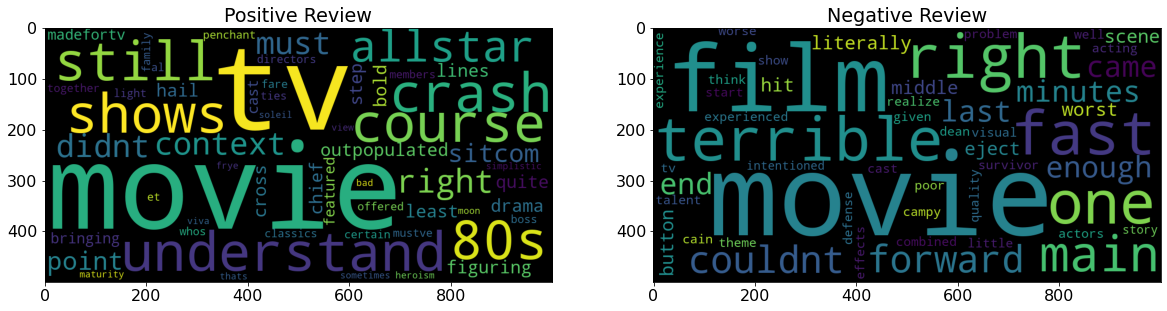

In [66]:
def plot_WordCloud(df):
    '''
    df: input dataframe 
    '''
    
    ind_pos = random.choice(list(df[df['sentiment']=='positive'].index))
    ind_neg = random.choice(list(df[df['sentiment']=='negative'].index))
    
    review_pos = df['processed'][ind_pos]
    review_neg = df['processed'][ind_neg]
    
    print('Positive review')
    print(review_pos)
    print('\n')
    
    print('Negative review')
    print(review_neg)
    
    cloud_pos = WordCloud(width=1000, height=500).generate(review_pos)
    cloud_neg = WordCloud(width=1000, height=500).generate(review_neg)
    
    plt.figure(figsize = (20,15))
    plt.subplot(1,2,1)
    plt.imshow(cloud_pos)
    plt.title('Positive Review')

    plt.subplot(1,2,2)
    plt.imshow(cloud_neg)
    plt.title('Negative Review')

    plt.show()
    
plot_WordCloud(data)

### 3. Data processing

Firstly, we devide the data into train, validation and test sets with the corresponding proportions are 70%, 20%, 10%

In [9]:
data['Label'] = data['sentiment'].apply(lambda x: 0 if x == 'negative' else 1)

data_0 = data[data['Label'] == 0]
data_1 = data[data['Label'] == 1]

train_size = int(0.7*25000)
val_size = int(0.2*25000)

data_train = pd.concat((data_0[:train_size], data_1[:train_size]), axis = 0)
data_val = pd.concat((data_0[train_size: (train_size + val_size)], data_1[train_size:(train_size + val_size)]), axis = 0)
data_test = pd.concat((data_0[(train_size + val_size):], data_1[(train_size + val_size):]), axis = 0)

X_train, y_train = list(data_train['processed']), np.array(data_train['Label'])
X_val, y_val = list(data_val['processed']), np.array(data_val['Label'])
X_test, y_test = list(data_test['processed']), np.array(data_test['Label'])

print('Train size:', len(X_train))
print('Validation size: ', len(X_val))
print('Test size: ', len(X_test))

Train size: 35000
Validation size:  10000
Test size:  5000


In [10]:
vocab_size = 10000
max_length = 500
trunc_type = 'post'
oov_tok = 'OOV'

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenization
token = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
token.fit_on_texts(X_train)
index_word = token.index_word

# Convert texts to sequences
train_seq = token.texts_to_sequences(X_train)
val_seq = token.texts_to_sequences(X_val)
test_seq = token.texts_to_sequences(X_test)

# Sequence padding
#Since the sequences have different lengtht, then we use padding method to put all sequences to the same length. 
#The parameter "maxlen" sets the maximum length of the output sequence. 
#    + If length of the input sequence is larger than "maxlen", then it is trunced to keep only #maxlen words, (truncating = 'pre': keep the previous part of the sequence; truncating = 'post': keep the posterior part of the sequence).
#    + If length of the input sequence is smaller than "maxlen", then 0 elements will be padded into the previous part of sequence (if padding = 'pre' - by defaut) or in the tail of the sequence (if padding = 'post').

train_pad = pad_sequences(train_seq, maxlen = max_length, padding = 'post', truncating = trunc_type)
val_pad = pad_sequences(val_seq, maxlen = max_length, padding = 'post', truncating = trunc_type)
test_pad = pad_sequences(test_seq, maxlen = max_length, padding = 'post', truncating = trunc_type)


In [11]:
# Shuffle the training set
p = np.random.permutation(len(train_pad))
train_pad = train_pad[p]
y_train = y_train[p]

## II. Build and train the model

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, AveragePooling1D, MaxPooling1D, Bidirectional, LSTM, Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# initial learning rate
init_lr = 0.001  
# learing rate schedule
lr_schedule = ExponentialDecay(init_lr, decay_steps = 10**4, decay_rate = 0.96, staircase = True)

embedding_dim = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length = max_length))
model.add(Conv1D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPooling1D(pool_size = 2))
model.add(Bidirectional(LSTM(64, dropout = 0.5, recurrent_dropout = 0.5)))
model.add(Dense(1, activation = 'sigmoid', kernel_regularizer=l2(0.01)))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# Define callbacks
checkpoint_cb = ModelCheckpoint('trained_model.keras', save_best_only = True)
early_stopping_cb = EarlyStopping(monitor='val_accuracy', patience = 5)

#plot_model(model, show_shapes = True)

H = model.fit(train_pad, y_train, 
             validation_data = (val_pad, y_val),
             epochs = 25,
             batch_size = 128,
             shuffle = True, 
             callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/25
274/274 [==============================] - 513s 2s/step - loss: 0.4271 - accuracy: 0.8083 - val_loss: 0.4089 - val_accuracy: 0.8196
Epoch 2/25
274/274 [==============================] - 490s 2s/step - loss: 0.2527 - accuracy: 0.9099 - val_loss: 0.2883 - val_accuracy: 0.8925
Epoch 3/25
274/274 [==============================] - 488s 2s/step - loss: 0.1950 - accuracy: 0.9347 - val_loss: 0.3141 - val_accuracy: 0.8875
Epoch 4/25
274/274 [==============================] - 496s 2s/step - loss: 0.1625 - accuracy: 0.9474 - val_loss: 0.3484 - val_accuracy: 0.8852
Epoch 5/25
274/274 [==============================] - 488s 2s/step - loss: 0.1345 - accuracy: 0.9609 - val_loss: 0.3419 - val_accuracy: 0.8852
Epoch 6/25
274/274 [==============================] - 489s 2s/step - loss: 0.1120 - accuracy: 0.9695 - val_loss: 0.4116 - val_accuracy: 0.8829
Epoch 7/25
274/274 [==============================] - 492s 2s/step - loss: 0.0982 - accuracy: 0.9748 - val_loss: 0.3739 - val_accuracy: 0.8828

<a name = 'Test_the_model'></a>
### III. Test the model on unseen dataset 

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      2500
           1       0.88      0.87      0.88      2500

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000



Balanced accuracy score:  87.82 %




<Figure size 360x360 with 0 Axes>

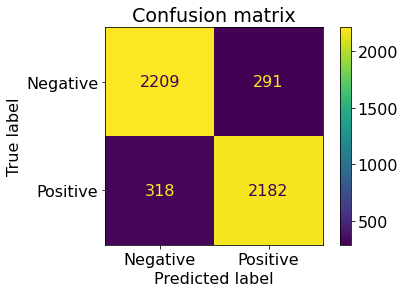

In [81]:
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, ConfusionMatrixDisplay
y_pred_proba = model.predict(test_pad)
y_pred = np.array([0 if proba < 0.5 else 1 for proba in y_pred_proba])

print(classification_report(y_test, y_pred))

print('\n')

print('Balanced accuracy score: ', np.round(balanced_accuracy_score(y_test, y_pred)*100, 2), '%')

print('\n')
cm = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels = ['Negative', 'Positive'])
plt.figure(figsize = (5,5))
cm.plot()
plt.title('Confusion matrix')
plt.show()


### IV. Conclusion 

In this project, we have discovered how to build and train a simple neural network for text classification problem, as well as how to prepare text files to feed the model. 

The accuracies of this model on the training set is 97.48%, on the validation set is 88.28% and 87.82% on the test set. 

There are also several ideas that you can try to improve the model performance as: 
+ change dimension of the embedding layer 
+ change hyperparameter values as the number of neurons in LSTM layer, dropout percentage, number of filters in Conv1D, ...

Besides, as the text data was converted into structured data (train_pad, val_pad, test_pad), hence you can also try to train some robust machine learning models like SVM, Random Forest, Gradient boosting classifier, ... on this data.
